[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/04_mcm.ipynb)

# Métodos Monte Carlo

En este post veremos nuestro primer método de aprendizaje para estimar funciones de valor y descubrir políticas óptimas. A diferencia de la programación dinámica, en la que asumimos que conocemos por completo el entorno y su comportamiento (por lo que no hay aprendizaje y solo pueden aplicarse al problema de planificación), los métodos de Monte Carlo aprenden directamente de la experiencia del agente (lo que los enmarca en la categoría de algorimtos *model-free*). En este caso, el agente interactúa con el entorno y va acumulando información sobre el mismo. A partir de esta información, el agente puede aprender a tomar decisiones óptimas.

Para ello se basan en la simple idea de promediar los retornos muestreados para calcular la función de valor. Para obtener buenas estimaciones, el agente debe interactuar con el entorno de manera episódica, es decir, debe empezar en un estado inicial y terminar en un estado final. En cada episodio, el agente va acumulando información sobre el entorno y aprendiendo a tomar decisiones óptimas. Esto, sin embargo, limita su aplicación a tareas con un final determinado, como juegos o tareas de planificación.

## Predicción (*policy evaluation*)

Nuestro objetivo es estimar el valor $v_{\pi}(s)$ de un estado $s$ bajo una política $\pi$ a partir de un conjuto de episodios en los que nuestro agente ha visitado $s$ siguiendo la política $\pi$. Teniendo en cuenta que la función de valor es el retorno esperado podemos aproximarla promediando los retornos de los episodios en los que el agente ha visitado $s$:

$$v_{\pi}(s) \approx \frac{1}{N(s)} \sum_{i=1}^{N(s)} G_i$$

donde $N(s)$ es el número de episodios en los que el agente ha visitado $s$ y $G_i$ es el retorno del episodio $i$. Podemos hacer esto solo la primera vez que el agente visita $s$ en cada epiodio (*first-visit MC*) o cada vez que el agente visita $s$ en cada episodio (*every-visit MC*). En ambos casos, la función de valor converge a $v_{\pi}(s)$ a medida que el número de visitas a $s$ aumenta.

Veamos un ejemplo de aplicación en un problema muy similar al del post anterior, el que tenemos un agente en un *grid world* cuyo objetivo es encontrar la salida $B$ partiendo del punto $A$.

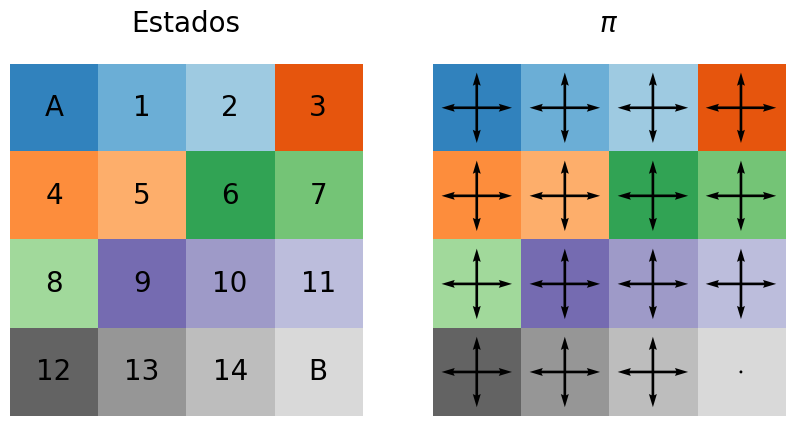

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_env(v, a=None, title="$v_k$"):
    v = v.reshape(4,4)
    if a is None:
        R, T = np.ones((4,4)), np.ones((4,4))
        L, B = -1.*R, -1.*T
    else:
        T = a[:,0].reshape((4,4))
        B = -1*a[:,1].reshape((4,4))
        R = a[:,2].reshape((4,4))
        L = -1*a[:,3].reshape((4,4))
    R[3,3] = 0
    T[3,3] = 0
    B[3,3] = 0
    L[3,3] = 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    zeros = np.zeros((4,4))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(4):
        for j in range(4):
            c = v[j,i]
            if (i==0 and j==0):
                ax1.text(i, j, 'A', va='center', ha='center', fontsize=20, color="black")
            elif (i==3 and j==3):
                ax1.text(i, j, 'B', va='center', ha='center', fontsize=20, color="black")
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=20, color="black")
    ax2.quiver(L, zeros, scale=10)
    ax2.quiver(R, zeros, scale=10)
    ax2.quiver(zeros, T, scale=10)
    ax2.quiver(zeros, B, scale=10)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("$\pi$", fontsize=20)
    plt.show()
    
estados = np.arange(16)
plot_env(estados, title="Estados")

Considerando una política inicial aleatoria, el agente podrá moverse arriba, abajo, derecha o izquierda en cada casilla (estado) con un 25% de probabilidad, obteniendo una recompensa de -1 por cada movimiento en el que no encuentre la salida.

In [2]:
from tqdm import tqdm

# política inicial (random)
pi = 0.25*np.ones((16, 4))

def eval_pol(pi, gamma=1, num_eps=100, v=None, seed=608, verbose=False):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos recompensas
    rs = [[] for _ in range(16)]
    # generar episodio siguiendo la política
    for e in tqdm(range(num_eps)):
        episodio, s = [], 0
        while s != 15:
            a = np.random.choice(4, p=pi[s])
            s_next = s + [-4 if s >= 4 else 0, 4 if s < 12 else 0, 1 if (s+1) % 4 else 0, -1 if s % 4 else 0][a] # top, bot, right, left
            if verbose:
                print(s, a, s_next)
            episodio.append((s, a, -1))
            s = s_next
        # retorno del episodio
        G, visited = 0, []
        for s, a, r in reversed(episodio):
            if s not in visited: # first visit
                visited.append(s)
                G = r + gamma*G
                rs[s].append(G)
    # promediar recompensas para estimar función de valor
    return np.array([np.mean(rs[s]) for s in range(16)])


100%|██████████| 1/1 [00:00<00:00, 1843.65it/s]

0 2 1
1 1 5
5 1 9
9 2 10
10 2 11
11 1 15



/home/juan/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juan/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


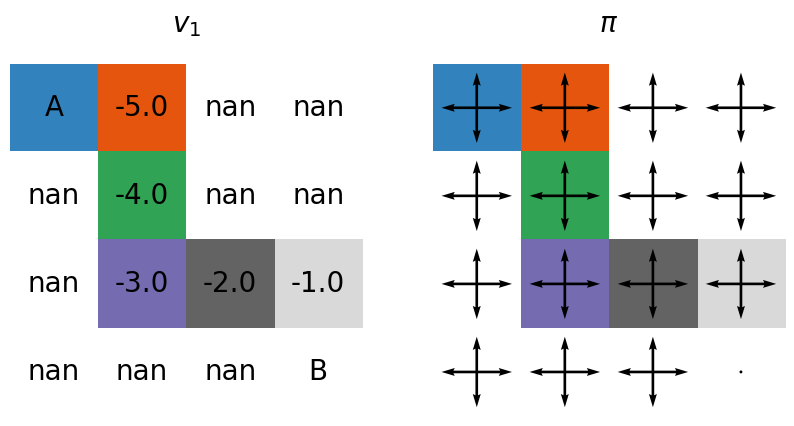

In [3]:
v = eval_pol(pi, num_eps=1, verbose=True)
plot_env(v, title="$v_{1}$")

A diferencia los algorimtos de programación dinámica, los métodos de Monte Carlo van aprendiendo a medida que van explorando el entorno. Si solo ejectuamos una iteración solo podremos actualizar los valores de aquellos estados visitados en ese episodio. A medida que ejecutamos más episodios, los valores de los diferentes estados visitados se van actualizando. Esto implica que, en problemas muy grandes, es posible que haya estados que nunca visitemos y, por tanto, no podamos estimar su valor.

100%|██████████| 2/2 [00:00<00:00, 1959.50it/s]


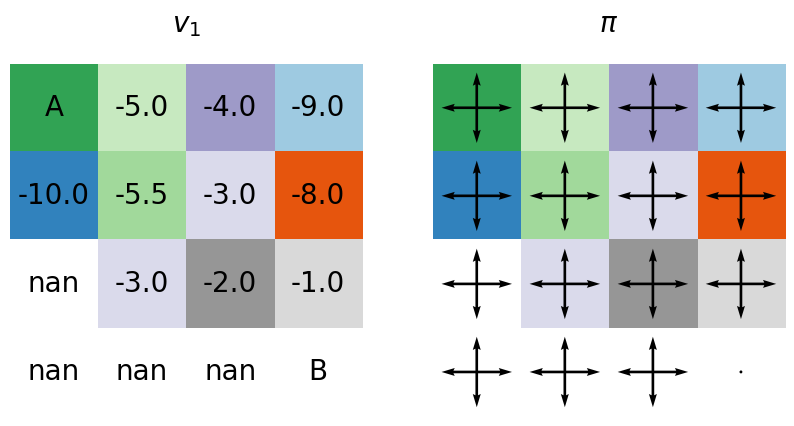

In [4]:
v = eval_pol(pi, num_eps=2)
plot_env(v, title="$v_{1}$")

100%|██████████| 10000/10000 [00:09<00:00, 1088.94it/s]


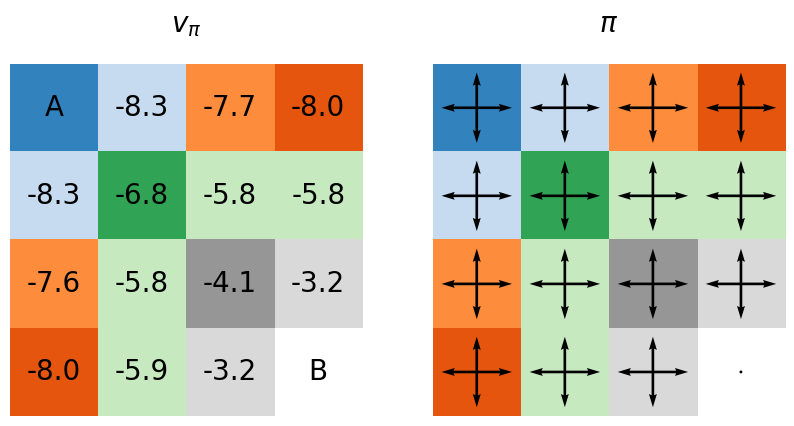

In [5]:
v = eval_pol(pi, num_eps=10000)
plot_env(v, title="$v_\pi$")

## Control (*policy iteration*)

Una vez visto como podemos estimar nuestra función de valor dada una política, el siguiente paso es aprender una política óptima. En el post anterior presentamos el algoritmo de *policy iteration*, que consistía en actualizar la política seleccionado aquellas acciones con un valor mayor de manera *greedy* (y, alternativamente, *value iteration* para mejorar las prestaciones). Para ello necesitamos la función de valor $q_{\pi}(s,a)$ para cada estado $s$ y acción $a$. Si disponemos de un modelo del enterno (como en el caso de DP) es posible derivar $q$ a partir de $v$ usando la dinámica del entorno. Sin embargo, en el caso de MC no disponemos de un modelo del entorno y, por tanto, no podemos calcular $q$ a partir de $v$. En este caso, deberemos estimar $q$ de manera similar a como hemos estimado $v$ en la sección anterior.

![](pics/gpi.PNG)

In [6]:
def eval_q(pi, gamma=1, num_eps=100, v=None, seed=608, verbose=False):
    seed = np.random.randint(1000) if seed is None else seed    
    np.random.seed(seed)
    # inicializamos recompensas
    rs = [[[] for _ in range(4)] for _ in range(16)]
    # generar episodio siguiendo la política
    for e in tqdm(range(num_eps)):
        episodio, s = [], 0
        while s != 15:
            a = np.random.choice(4, p=pi[s])
            s_next = s + [-4 if s >= 4 else 0, 4 if s < 12 else 0, 1 if (s+1) % 4 else 0, -1 if s % 4 else 0][a] # top, bot, right, left
            if verbose: print(s, a, s_next)
            episodio.append((s, a, -1))
            s = s_next
        # retorno del episodio
        G, visited = 0, []
        for s, a, r in reversed(episodio):
            if (s, a) not in visited: # first visit
                visited.append((s,a))
                G = r + gamma*G
                rs[s][a].append(G)
    # promediar recompensas para estimar función de valor
    return np.array([[np.mean(rs[s][a]) for a in range(4)] for s in range(16)])

In [7]:
pi = 0.25*np.ones((16, 4))

q = eval_q(pi, num_eps=1, verbose=True)
q

100%|██████████| 1/1 [00:00<00:00, 2144.33it/s]

0 2 1
1 1 5
5 1 9
9 2 10
10 2 11
11 1 15


array([[nan, nan, -6., nan],
       [nan, -5., nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, -4., nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, -3., nan],
       [nan, nan, -2., nan],
       [nan, -1., nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

In [8]:
q = eval_q(pi, num_eps=5000)
q

100%|██████████| 5000/5000 [00:04<00:00, 1063.04it/s]


array([[-23.42222222, -20.79147756, -20.81756245, -23.23408126],
       [-21.99130763, -19.22705771, -19.70830671, -22.13495879],
       [-21.13944043, -17.74696049, -18.89634146, -21.12626878],
       [-20.5136948 , -16.11467487, -20.6613348 , -20.28988235],
       [-22.29951857, -19.48735191, -19.36064   , -22.38825324],
       [-21.46096654, -17.39343708, -17.03153925, -21.30033495],
       [-20.0327368 , -14.44767662, -15.98722555, -20.40253165],
       [-19.96237414, -10.1184948 , -17.85066372, -18.94328219],
       [-21.51894094, -19.13656747, -17.60842027, -21.23743661],
       [-20.24027835, -16.18939394, -14.11263941, -20.34448306],
       [-19.24654926, -10.74371859, -10.84964891, -18.88246445],
       [-18.15585242,  -1.        , -12.62299465, -16.49253731],
       [-20.22699673, -20.27509706, -16.21826965, -20.45540691],
       [-18.6499527 , -17.83521202, -10.36297494, -19.79166667],
       [-16.21281741, -12.64542373,  -1.        , -18.68640898],
       [         nan,    

Y ahora ya podemos actualizar nuestra política de manera *greedy* con respecto a $q$

In [9]:
def greedy_pol(q):
	p = np.zeros((16,4))
	p[range(16), q.argmax(axis=1)] = 1 
	return p

100%|██████████| 1000/1000 [00:00<00:00, 10016.54it/s]


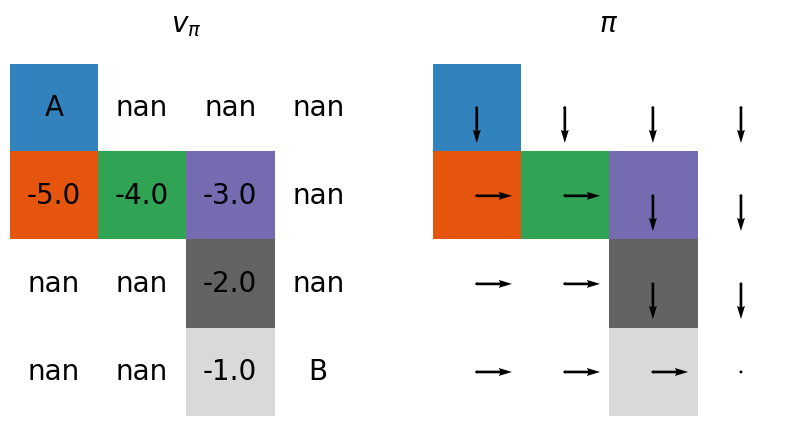

In [10]:
pi = greedy_pol(q)
v = eval_pol(pi, num_eps=1000)
plot_env(v, pi, title="$v_\pi$")

Aquí nos encontramos uno de los problemas fundamentales del AxR, y es que tras haber sampleado 5000 episodios para estimar la función de valor, una vez actuemos de manera *greedy* con respecto a esta función nuestro agente seguirá la misma trayectoria en cada episodio. Esto no es problemático en un ejemplo tan sencillo, en el que el agente se puede hacer una buena idea del camino óptimo desde el principio. Sin embargo, en problemas grandes con muchos estados diferentes es muy poco probable que nuestro agente encuentre la política óptima desde el principio. Es por esto que queremos que nuestro agente siga explorando el entorno y aprendiendo de la experiencia a medida que va mejorando su política. 

Veamos un nuevo ejemplo, ahora con una versión modificada de nuestro *grid world* en la que el agente se verá "empujado" hacia arriba en unas posiciones determinadas (*windy grid world*).

![windy](./pics/windy.png)

In [11]:
def plot_env_windy(v, w=10, h=7, start=(3, 0), end=(3, 7), a=None, title="$v_k$", scale=10):
    shape = (h, w)
    v = v.reshape(shape)
    if a is None:
        R, T = np.ones(shape), np.ones(shape)
        L, B = -1.*R, -1.*T
    else:
        T = a[:,0].reshape(shape)
        B = -1*a[:,1].reshape(shape)
        R = a[:,2].reshape(shape)
        L = -1*a[:,3].reshape(shape)
    R[end] = T[end] = B[end] = L[end] = 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(w):
        for j in range(h):
            c = v[j,i]
            if (j, i) == start:
                ax1.text(i, j, 'A', va='center', ha='center', fontsize=10, color="black")
            elif (j, i) == end:
                ax1.text(i, j, 'B', va='center', ha='center', fontsize=10, color="black")
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=10, color="black")
    zeros = np.zeros(shape)
    ax2.quiver(L, zeros, scale=scale)
    ax2.quiver(R, zeros, scale=scale)
    ax2.quiver(zeros, T, scale=scale)
    ax2.quiver(zeros, B, scale=scale)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("$\pi$", fontsize=20)
    plt.show()

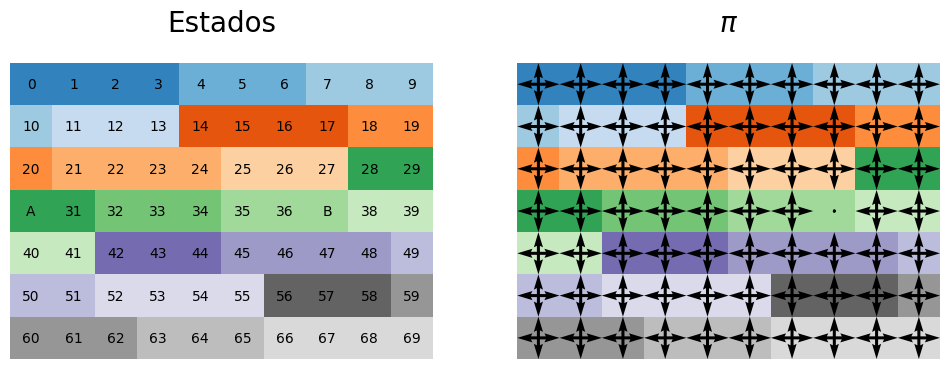

In [12]:
w, h = 10, 7
estados = np.arange(w*h)
plot_env_windy(estados, w, h, title="Estados", scale=20)

In [13]:
def apply_wind(s, w, wind):
    # get the column
    col, row = s % w, s // w
    if row == 0: return 0
    # find column in wind dict
    return min(wind[col], row)

def eval_q_windy(pi, w, h, start_state, end_state, wind, gamma=0.9, num_eps=100, v=None, seed=919, verbose=False):
    seed = np.random.randint(1000) if seed is None else seed    
    np.random.seed(seed)
    # inicializamos recompensas
    rs = [[[] for _ in range(4)] for _ in range(h*w)]
    # generar episodio siguiendo la política
    eps_len = []
    for e in tqdm(range(num_eps)):
        episodio, s = [], start_state
        its = 0
        while s != end_state:
            a = np.random.choice(4, p=pi[s])
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)
            if verbose: print(s, a, s_next)
            episodio.append((s, a, -1))
            s = s_next
            its += 1
        eps_len.append(its)
        # retorno del episodio
        G, visited = 0, []
        for s, a, r in reversed(episodio):
            if (s, a) not in visited: # first visit
                visited.append((s,a))
                G = r + gamma*G
                rs[s][a].append(G)
    # promediar recompensas para estimar función de valor
    return np.array([[np.mean(rs[s][a]) for a in range(4)] for s in range(h*w)]), eps_len

def eval_pol_windy(pi, w, h, start_state, end_state, wind, gamma=0.9, num_eps=100, v=None, seed=919, verbose=False, max_its=1000):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos recompensas
    rs = [[] for _ in range(h*w)]
    # generar episodio siguiendo la política
    for e in tqdm(range(num_eps)):
        episodio, s = [], start_state
        its = 0
        while s != end_state and its < max_its:
            a = np.random.choice(4, p=pi[s])
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)
            if verbose:
                print(s, a, s_next, its)
            episodio.append((s, a, -1))
            s = s_next
            its += 1
        # retorno del episodio
        G, visited = 0, []
        for s, a, r in reversed(episodio):
            if s not in visited: # first visit
                visited.append(s)
                G = r + gamma*G
                rs[s].append(G)
        
    # promediar recompensas para estimar función de valor
    return np.array([np.mean(rs[s]) for s in range(h*w)])

def greedy_pol_windy(q, w, h):
    p = np.zeros((w*h,4))
    # set nans to -inf
    q[np.isnan(q)] = -np.inf
    p[range(w*h), q.argmax(axis=1)] = 1 
    return p

100%|██████████| 1/1 [00:00<00:00, 2220.38it/s]


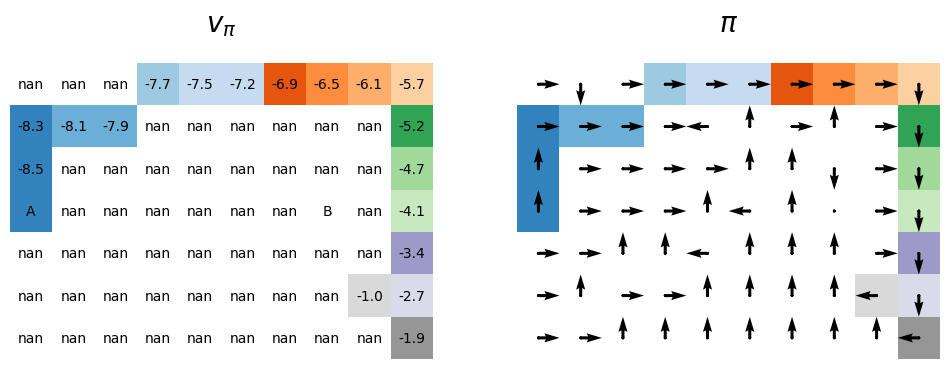

In [14]:
h, w, start, end = 7, 10, 30, 37
wind = [0,0,0,1,1,1,2,2,1,0] # value applied at each column

pi = 0.25*np.ones((h*w, 4))
q, lens = eval_q_windy(pi, w, h, start, end, wind, num_eps=100)
pi = greedy_pol_windy(q, w, h)
v = eval_pol_windy(pi, w, h, start, end, wind, num_eps=1) # siempre haremos las mismas acciones
plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

Para seguir explorando usamos el algoritmo $\epsilon$-*greedy* que presentamos en el post sobre exploración, en el que el agente sigue la política óptima con probabilidad $1-\epsilon$ y con probabilidad $\epsilon$ llevará a cabo una acción aleatoria. De esta manera, el agente sigue explorando el entorno y aprendiendo de la experiencia a medida que va mejorando su política.

In [15]:
def eval_q_windy_e(pi, w, h, start_state, end_state, wind, epsilon=0.1, gamma=0.9, num_eps=100, v=None, seed=919, verbose=False, pbar=True):
    seed = np.random.randint(1000) if seed is None else seed    
    np.random.seed(seed)
    # inicializamos recompensas
    rs = [[[] for _ in range(4)] for _ in range(h*w)]
    # generar episodio siguiendo la política
    if pbar: p = tqdm(range(num_eps))
    else: p = range(num_eps)
    eps_len = []
    for e in p:
        episodio, s = [], start_state
        its = 0
        while s != end_state:
            # epsilon-greedy
            if np.random.rand() < 1. - epsilon:
                a = np.random.choice(4, p=pi[s])
            else:
                a = np.random.choice(4)
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)
            if verbose: print(s, a, s_next)
            episodio.append((s, a, -1))
            s = s_next
            its += 1
        eps_len.append(its)
        # retorno del episodio
        G, visited = 0, []
        for s, a, r in reversed(episodio):
            if (s, a) not in visited: # first visit
                visited.append((s,a))
                G = r + gamma*G
                rs[s][a].append(G)
    # promediar recompensas para estimar función de valor
    return np.array([[np.mean(rs[s][a]) for a in range(4)] for s in range(h*w)]), eps_len

100%|██████████| 1/1 [00:00<00:00, 2240.55it/s]


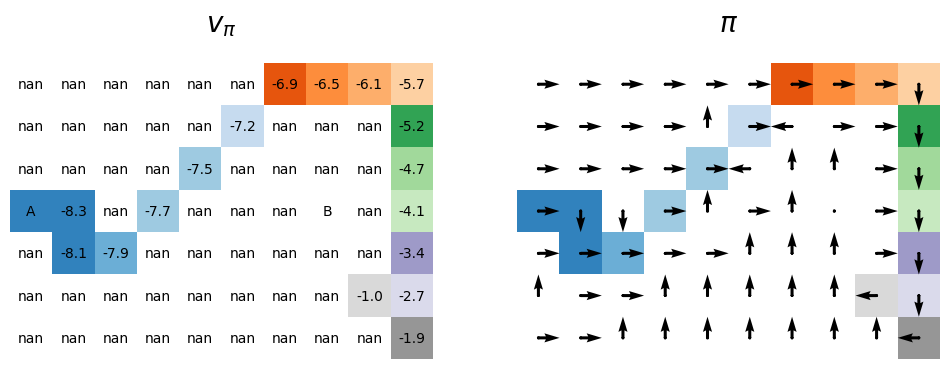

In [16]:
epsilon = 0.1

pi = 0.25*np.ones((h*w, 4))
q, lens = eval_q_windy_e(pi, w, h, start, end, wind, epsilon, num_eps=100)
pi = greedy_pol_windy(q, w, h)
v = eval_pol_windy(pi, w, h, start, end, wind, num_eps=1) 
plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

Podemos repetir el proceso tantas veces como queramos para obtener una política cada vez mejor, aunque no es necesario esperar a que nuestro agente haya terminado todos los episodos para ello. Una forma más rápida y eficiente de encontrar la política óptima consiste en actualizarla cada vez que el agente termina un solo episodio. 

![](pics/egpi.PNG)

In [79]:
def value_iteration(w, h, start, end, wind, epsilon0=0.1, max_its=100):
    pi = 0.25*np.ones((h*w, 4))
    lens, eps = [], []
    for it in tqdm(range(max_its)):
        # reduce epsilon linearliy
        epsilon = epsilon0 * (1 - it/max_its)
        q, _lens = eval_q_windy_e(pi, w, h, start, end, wind, epsilon, num_eps=1, pbar=False) # mejoramos politica con 1 episodio
        pi = greedy_pol_windy(q, w, h)
        lens.append(np.mean(_lens))
        eps.append(epsilon)
    v = eval_pol_windy(pi, w, h, start, end, wind, num_eps=1) 
    return v, pi, lens, eps

100%|██████████| 1/1 [00:00<00:00, 2154.24it/s]


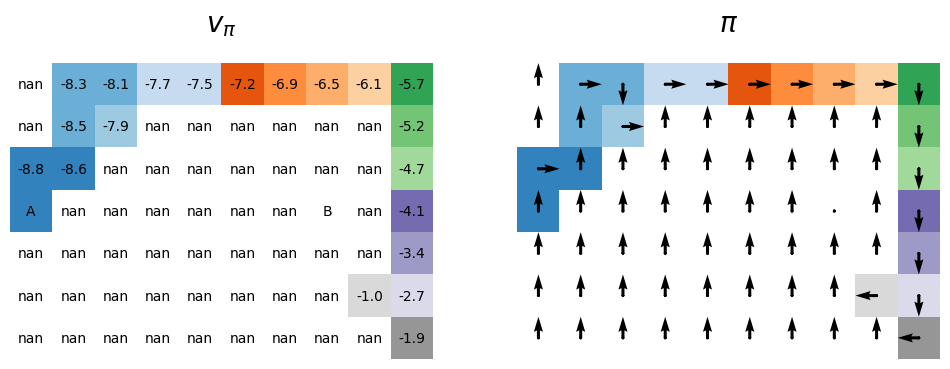

In [80]:
v, pi, lens, eps = value_iteration(w, h, start, end, wind, epsilon0=0.999, max_its=100)
plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

## Resumen

En este post hemos introducido los conceptor básicos de los métodos de Monte Carlo. Como hemos visto son métodos que no requiren de un modelo del entorno (*model-free*) y que aprenden de la experiencia del agente. Para calcular la función de valor se basan en el promediado de los retornos obtenidos en diferentes episodios, que luego usamos para actualizar la política utilizando el algoritmo $\epsilon$-*greedy* para que nuestro agente siga explorando el entorno. Existen mejoras que introducen conceptos como el *importance sampling* o aprendizaje *off-policy*, en el que usamos una política diferente para guíar al agente de la que usamos durante su aprendizaje. En el siguiente post hablaremos sobre los métodos de *TD* (*Temporal Difference*), que son una mejora de los métodos de Monte Carlo que no requiren de la finalización de un episodio para actualizar la función de valor.